In [1]:
# The radial velocity measured by the radar is measured by detecting the phase shift between the
# transmitted pulse and the pulse received by the radar. However, using this methodology, it is
# only possible to detect phase shifts within +- 2pi due to the periodicity of the transmitted wave.
# Therefore, for example, a phase shift of 3pi would erroneously be detected as a phase shift of -pi
# and give an incorrect value of velocity when retrieved by the radar. This phenomena is called aliasing.
# The maximium unambious velocity that can be detected by the radar before aliasing occurs is called
# the Nyquist velocity.

# First import needed modules.
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Read the radar data.

radar = pyart.io.read("MDV-20150805-084449-PPIVol.nc")

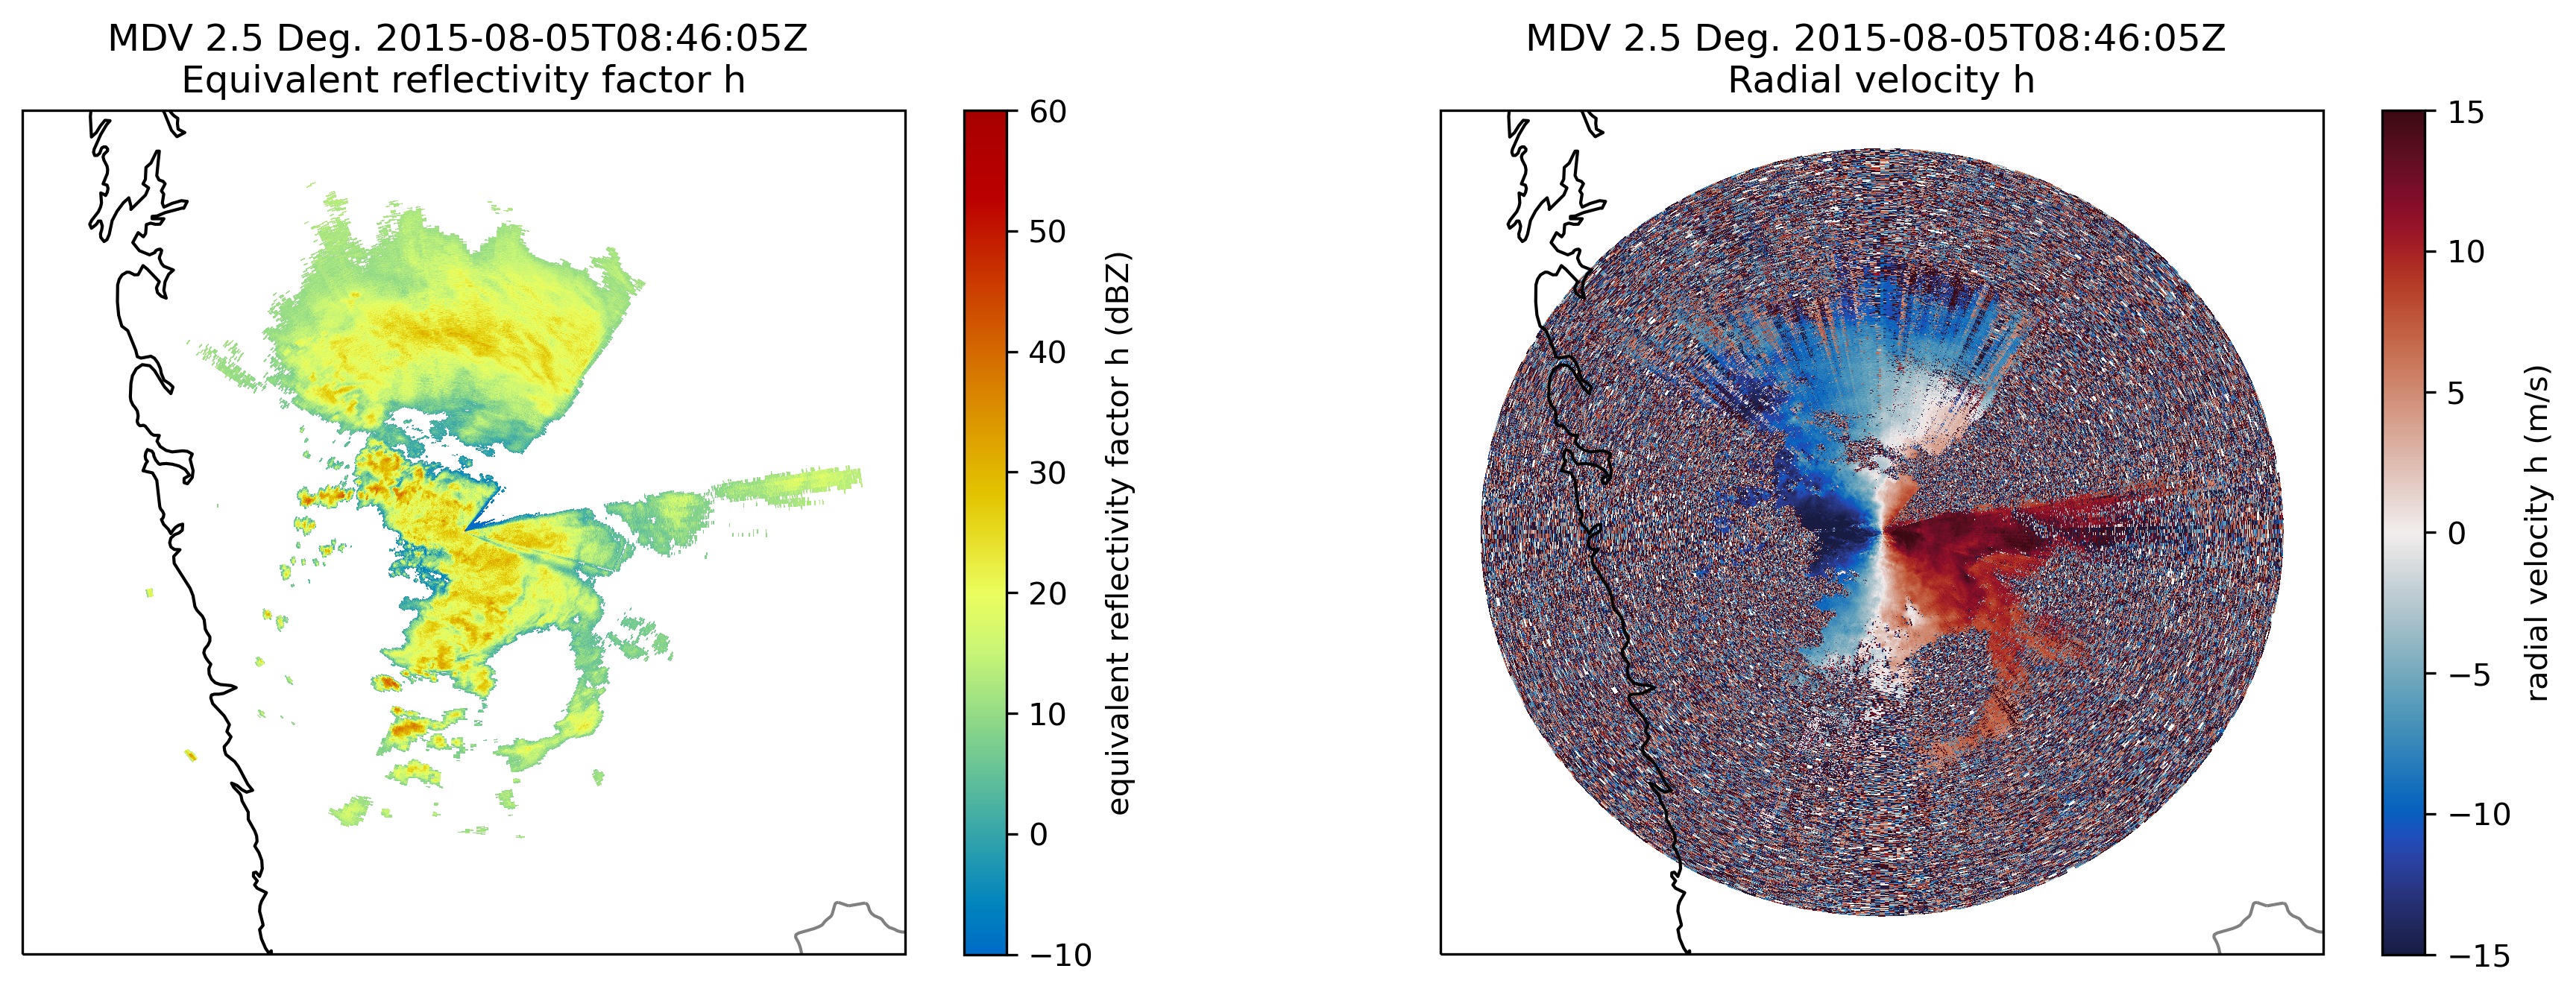

In [6]:
fig = plt.figure(figsize=[15,5],dpi=300)
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('DBZH', sweep=2, resolution='10m',
                     vmin=-10, vmax=60,
                     projection=ccrs.PlateCarree())

ax2 = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('VELH', sweep=2, resolution='10m',
                     vmin=-15, vmax=15,
                     projection=ccrs.PlateCarree(), cmap='pyart_balance')
plt.show()


In [7]:

# First, for dealiasing to work efficiently, we need to use a GateFilter. Looks like, and we need to
# do some preprocessing on the data to remove noise and clutter. Thankfully, Py-ART gives us the
# capability to do this. As a simple filter in this example, we will first calculate the velocity texture
# using Py-ART's calculate_velocity_texture function. The velocity texture is the standard deviation of
# velocity surrounding a gate. This will be higher in the presence of noise.


radar.instrument_parameters['nyquist_velocity']['data']


masked_array(data=[23.625, 23.625, 23.625, ..., 23.625, 23.625, 23.625],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [12]:
# Set the nyquist to what we see in the instrument parameter above.
# Calculate the velocity texture
vel_texture = pyart.retrieve.calculate_velocity_texture(radar, vel_field='VELH', wind_size=3, nyq=23.625)
radar.add_field('velocity_texture', vel_texture, replace_existing=True)

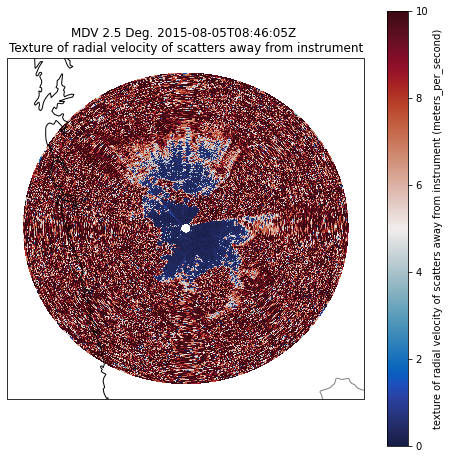

In [13]:
# Let us see what the velocity texture looks like.
fig = plt.figure(figsize=[8, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('velocity_texture', sweep=2, resolution='10m',
                     vmin=0, vmax=10,
                     projection=ccrs.PlateCarree(), cmap='pyart_balance')
plt.show()

In [14]:
# Plot a histogram of velocity texture to get a better idea of what values correspond to
# hydrometeors and what values of texture correspond to artifacts.
# In the below example, a threshold of 3 would eliminate most of the peak corresponding to noise
# around 6 while preserving most of the values in the peak of ~0.5 corresponding to hydrometeors.
hist, bins = np.histogram(radar.fields['velocity_texture']['data'], bins=150)
bins = (bins[1:]+bins[:-1])/2.0
plt.plot(bins, hist)
plt.xlabel('Velocity texture')
plt.ylabel('Count')

ValueError: autodetected range of [nan, nan] is not finite